In [1]:
from keras.models import Sequential, load_model
from keras.layers import Embedding, Conv1D, Dense, Flatten, Dropout, MaxPooling1D
from keras.datasets import reuters
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import model_to_dot
from gensim.models import word2vec
import numpy
from sklearn.preprocessing import LabelBinarizer
from IPython.display import SVG
(x_train, y_train), (x_test, y_test) = reuters.load_data(path="reuters.npz", 
                                                         num_words=None, 
                                                         skip_top=0, 
                                                         maxlen=None, 
                                                         test_split=0.2, 
                                                         seed=113, 
                                                         start_char=1, 
                                                         oov_char=2, 
                                                         index_from=3)

Using TensorFlow backend.


In [2]:
offset = 3
reuters_map = dict((index + offset, word) for (word, index) in reuters.get_word_index().items())
reuters_map[0] = 'PADDING'
reuters_map[1] = 'START'
reuters_map[2] = 'UNKNOWN'

In [3]:
' '.join([reuters_map[word_index] for word_index in x_train[0]])

'START mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [4]:
train_sentences = [['PADDING'] + [reuters_map[word_index] for word_index in review] for review in x_train]
test_sentences = [['PADDING'] + [reuters_map[word_index] for word_index in review] for review in x_test]
# test_sentences

In [5]:
reuters_wv_model = word2vec.Word2Vec(train_sentences + test_sentences + ['UNKNOWN'], min_count=1)

In [6]:
reuters_wordvec = reuters_wv_model.wv
reuters_wv_model.wv.get_vector('snake')

reuters_wv_model.wv.vectors # list of word vectors

array([[ 0.29345626, -0.7750187 ,  0.22822663, ..., -0.08673308,
        -3.2106571 , -0.08949522],
       [-1.9518943 ,  0.48839745, -1.7265432 , ..., -0.65465045,
        -2.2256184 , -0.5999684 ],
       [ 0.40988147, -0.7328701 , -0.45011625, ...,  1.1804185 ,
        -2.887608  , -0.29957724],
       ...,
       [-0.03466025,  0.05016937,  0.02303992, ..., -0.06655001,
        -0.02845289, -0.05237921],
       [-0.03770472,  0.06859544,  0.02165744, ..., -0.08396146,
        -0.03245724, -0.07030506],
       [-0.03494635,  0.05537092,  0.02854297, ..., -0.07413835,
        -0.03133663, -0.04956329]], dtype=float32)

In [7]:
# shorten and pad
lengths = [len(review) for review in x_train.tolist() + x_test.tolist()]
print('Longest review: {} Shortest review: {}'.format(max(lengths), min(lengths)))

Longest review: 2376 Shortest review: 2


In [8]:
cutoff = 500
print('{} reviews out of {} are over {}.'.format(
    sum([1 for length in lengths if length > cutoff]), 
    len(lengths), 
    cutoff))

450 reviews out of 11228 are over 500.


In [9]:
from keras.preprocessing import sequence
x_train_padded = sequence.pad_sequences(x_train, maxlen=cutoff)
x_test_padded = sequence.pad_sequences(x_test, maxlen=cutoff)
len(x_train_padded)

8982

In [10]:
model = Sequential()
embedding_layer = reuters_wordvec.get_keras_embedding(train_embeddings=False)
embedding_layer.input_length = cutoff

In [11]:
model.add(embedding_layer)

In [12]:
# verify that embedding layer works the same as regular wordvec
model.predict(numpy.array([[reuters_wordvec.vocab["W"].index]]))[0][0] == reuters_wordvec["W"]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [13]:
y_train # 0 to 45 (46 categories)... need to onehot encode so that we can do softmax with a good fit

array([ 3,  4,  3, ..., 25,  3, 25])

In [14]:
onehot_enc = LabelBinarizer()
y_train_onehot = onehot_enc.fit_transform(y_train)
y_test_onehot = onehot_enc.fit_transform(y_test)

In [15]:
model.add(Conv1D(filters=50, strides=2, kernel_size=5, activation='relu'))
model.add(Dropout(0.5))
model.add(Conv1D(filters=50, strides=2, kernel_size=7, activation='relu'))
model.add(MaxPooling1D(pool_size=3, strides=None, padding='valid', data_format='channels_last'))
model.add(Dropout(0.5))
model.add(Conv1D(filters=50, strides=2, kernel_size=5, activation='relu'))
model.add(Dropout(0.5))
model.add(Conv1D(filters=50, strides=2, kernel_size=7, activation='relu'))
model.add(MaxPooling1D(pool_size=3, strides=None, padding='valid', data_format='channels_last'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=46, activation='softmax')) # 46 topics
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [16]:
checkpt = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)
model.fit(x_train_padded, y_train_onehot, epochs=1, batch_size=128, validation_data=(x_test_padded, y_test_onehot), callbacks=[checkpt])


Train on 8982 samples, validate on 2246 samples
Epoch 1/1
8982/8982 [==============================] - 15s 2ms/step - loss: 2.9921 - categorical_accuracy: 0.2829 - val_loss: 3.2654 - val_categorical_accuracy: 0.3620

Epoch 00001: val_loss improved from inf to 3.26543, saving model to weights.hdf5


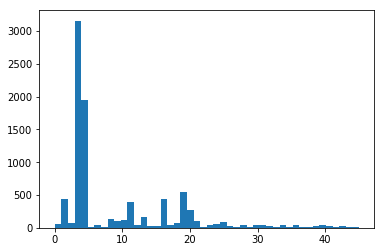

In [20]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(y_train, bins=46)
plt.show() # guess reuters has a lot of articles about the same topics

In [19]:
model = load_model("BEST_reuters_weights_64.hdf5") # trained 1000 epochs on bandersnatch
SVG(model_to_dot(model).create(prog='dot', format='svg'))

scores = model.evaluate(x_test_padded, y_test_onehot)
print('loss: {} accuracy: {}'.format(*scores))

2246/2246 [==============================] - 2s 778us/step
loss: 1.492768557923029 accuracy: 0.6393588601959038
